### Neural style transfer in PyTorch

This tutorial implements the "slow" neural style transfer based on the AlexNet model.
However, you can also use any model from VGG family from torchvision.models.

Please note, that any other model from torchvision.models will not work properly with this code due to the complex model class internal structure.

_Reference:based on [YSDA Materials](https://github.com/yandexdataschool/Practical_DL/blob/spring2019/week06_style_transfer/style_transfer_pytorch.ipynb). Closely follows the official neural style tutorial you can find [here](http://pytorch.org/tutorials/advanced/neural_style_tutorial.html)._

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import torch, torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import models, transforms
from tqdm.auto import tqdm
import scipy.ndimage as nd

In [2]:
# desired size of the output image
imsize = 512   # REDUCE THIS TO 128 IF THE OPTIMIZATION IS TOO SLOW FOR YOU
def image_loader(image_name):
    image = Image.open(image_name).resize((imsize, imsize), Image.ANTIALIAS)
    image = np.transpose(np.array(image), (2,0,1))
    image = image / image.max()
    image = Variable(dtype(image))
    # fake batch dimension required to fit network's input dimensions
    image = image.unsqueeze(0)
    return image

use_cuda = torch.cuda.is_available()

print("torch", torch.__version__)
if use_cuda:
    print("Using GPU.")
else:
    print("Not using GPU.")
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor

torch 1.6.0+cu101
Using GPU.


In [3]:
import os
os.makedirs('images', exist_ok=True)

In [4]:
!wget -q https://i.kym-cdn.com/entries/icons/mobile/000/030/157/womanyellingcat.jpg -O images/my_img.jpg
!wget -q https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/450px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg -O images/art.jpg
content_img = image_loader("images/my_img.jpg").type(dtype)
style_img = image_loader("images/art.jpg").type(dtype)

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

### Draw input images

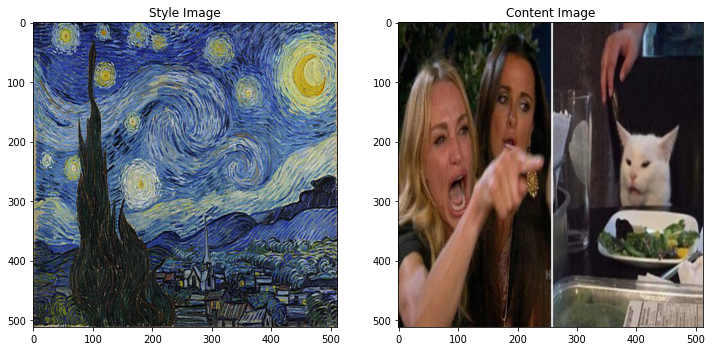

In [5]:
def imshow(tensor, title=None):
    image = tensor.detach().clone().cpu()  # we clone the tensor to not do changes on it
    image = image.view(3, imsize, imsize)  # remove the fake batch dimension
    image = image.numpy().transpose([1,2,0])
    plt.imshow(image / np.max(image))
    if title is not None:
        plt.title(title)

plt.figure(figsize=[12,6])
plt.subplot(1,2,1)
imshow(style_img.data, title='Style Image')
plt.subplot(1,2,2)
imshow(content_img.data, title='Content Image')

### Define Style Transfer Losses

Let's define two loss functions: content and style losses.

Content loss is simply a pointwise mean squared error of high-level features while style loss is the error between gram matrices of intermediate feature layers.

To obtain the feature representations we use a pre-trained VGG19 network.

In [6]:
import torchvision.models as models

cnn = models.alexnet(pretrained=True).features

# move it to the GPU if possible:
if use_cuda:
    cnn = cnn.cuda()

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth


In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target, weight):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        self.target = target.detach() * weight
        self.weight = weight

    def forward(self, input):
        self.loss = F.mse_loss(input * self.weight, self.target)
        return input.clone()

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

In [8]:
def gram_matrix(in_tensor):
    B, C, H, W = in_tensor.size() 
    # B=batch size(=1)
    # C=number of feature maps
    # (H,W)=dimensions of a feature map (N=c*d)

    features = in_tensor.view(B * C, H * W)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(B * C * H * W)
    
class StyleLoss(nn.Module):

    def __init__(self, target, weight):
        super(StyleLoss, self).__init__()
        self.target = target.detach() * weight
        self.weight = weight

    def forward(self, input):
        self.G = gram_matrix(input)
        self.G.mul_(self.weight)
        self.loss = F.mse_loss(self.G, self.target)
        return input.clone()

    def backward(self, retain_graph=True):
        self.loss.backward(retain_graph=retain_graph)
        return self.loss

### Style transfer pipeline

We can now define a unified "model" that computes all the losses on the image triplet (content image, style image, optimized image) so that we could optimize them with backprop (over image pixels).

In [9]:
content_weight=1            # coefficient for content loss
style_weight=1000          # coefficient for style loss
content_layers=('conv_4',)  # use these layers for content loss
style_layers=('conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5') # use these layers for style loss

In [11]:
content_losses = []
style_losses = []

model = nn.Sequential()  # the new Sequential module network
# move these modules to the GPU if possible:
if use_cuda:
    model = model.cuda()

i = 1
for layer in list(cnn):
    if isinstance(layer, nn.Conv2d):
        name = "conv_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).clone()
            target_feature_gram = gram_matrix(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

    if isinstance(layer, nn.ReLU):
        name = "relu_" + str(i)
        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).clone()
            content_loss = ContentLoss(target, content_weight)
            model.add_module("content_loss_" + str(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).clone()
            target_feature_gram = gram_matrix(target_feature)
            style_loss = StyleLoss(target_feature_gram, style_weight)
            model.add_module("style_loss_" + str(i), style_loss)
            style_losses.append(style_loss)

        i += 1

    if isinstance(layer, nn.MaxPool2d):
        name = "pool_" + str(i)
        model.add_module(name, layer)  # ***

### Optimization

We can now optimize both style and content loss over input image.

In [26]:
input_image = Variable(content_img.clone().data, requires_grad=True)
optimizer = torch.optim.Adam([input_image])

In [34]:
num_steps = 1000

for i in range(num_steps):
    # correct the values of updated input image
    input_image.data.clamp_(0, 1)

    res = model(input_image)
    style_score = 0
    content_score = 0
    for sl in style_losses:
        style_score += sl.backward()
    for cl in content_losses:
        content_score += cl.backward()
        
    if i % 100 == 0:  # <--- adjust the value to see updates more frequently
        
        print('Step # {} Style Loss : {:4f} Content Loss: {:4f}'.format(
            i, style_score.detach().cpu().numpy(), content_score.detach().cpu().numpy()))
        plt.figure(figsize=[10,10])
        imshow(input_image)
        plt.show()  

    
    loss = style_score + content_score
    optimizer.step(lambda: loss)
    optimizer.zero_grad()
    
# a last correction...
input_image.data = input_image.data.clamp(0, 1)

Output hidden; open in https://colab.research.google.com to view.

### Final image

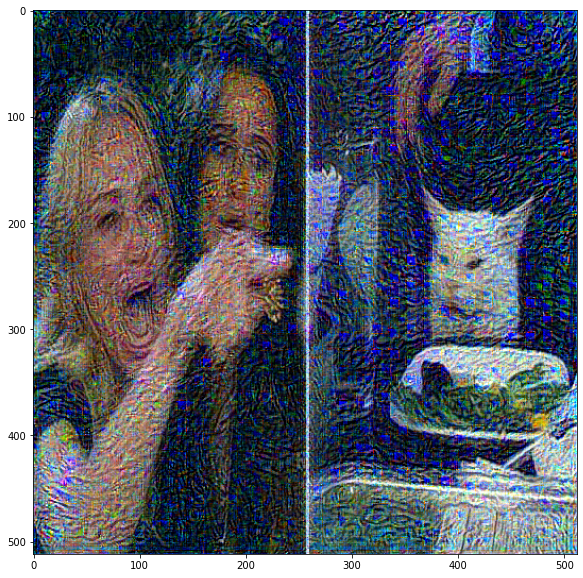

In [35]:
plt.figure(figsize=[10,10])
imshow(input_image.data)
plt.show()

# Let's Dream

In [ ]:
That's what happens when you play with some ideas, that are proposed [here](https://ai.googleblog.com/2015/06/inceptionism-going-deeper-into-neural.html).

In [29]:
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

preprocess = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean, std)])

def deprocess(image_np):
    image_np = image_np.squeeze().transpose(1, 2, 0)
    image_np = image_np * std.reshape((1, 1, 3)) + mean.reshape((1, 1, 3))
    image_np = np.clip(image_np, 0.0, 255.0)
    return image_np

def clip(image_tensor):
    for c in range(3):
        m, s = mean[c], std[c]
        image_tensor[0, c] = torch.clamp(image_tensor[0, c], -m / s, (1 - m) / s)
    return image_tensor

def dream(image, model, iterations, lr):
    """ Updates the image to maximize outputs for n iterations """
    Tensor = torch.cuda.FloatTensor if torch.cuda.is_available else torch.FloatTensor
    image = Variable(Tensor(image), requires_grad=True)
    for i in range(iterations):
        model.zero_grad()
        out = model(image)
        loss = out.norm()
        loss.backward()
        avg_grad = np.abs(image.grad.data.cpu().numpy()).mean()
        norm_lr = lr / avg_grad
        image.data += norm_lr * image.grad.data
        image.data = clip(image.data)
        image.grad.data.zero_()
    return image.cpu().data.numpy()


def deep_dream(image, model, iterations, lr, octave_scale, num_octaves):
    """ Main Deep Dream processing """
    image = preprocess(image).unsqueeze(0).cpu().data.numpy()

    # Extract image representations for each octave
    octaves = [image]
    for _ in range(num_octaves - 1):
        octaves.append(nd.zoom(octaves[-1], (1, 1, 1 / octave_scale, 1 / octave_scale), order=1))

    detail = np.zeros_like(octaves[-1])
    for octave, octave_base in enumerate(tqdm(octaves[::-1], desc="Dreaming")):
        if octave > 0:
            # Upsample detail to new octave dimension
            detail = nd.zoom(detail, np.array(octave_base.shape) / np.array(detail.shape), order=1)
        # Add deep dream detail from previous octave to new base
        input_image = octave_base + detail
        # Get new deep dream image
        dreamed_image = dream(input_image, model, iterations, lr)
        # Extract deep dream details
        detail = dreamed_image - octave_base

    return deprocess(dreamed_image)

In [30]:
# you can play with the parameters
layer_num = 32
iterations = 100
octave_scale = 1.2
num_octaves = 3
lr = 0.01

In [31]:
image = Image.open("images/my_img.jpg").resize((256, 256))
# Define the model
network = models.vgg19(pretrained=True)
layers = list(network.features.children())
model = nn.Sequential(*layers[: (layer_num + 1)])
if torch.cuda.is_available:
    model = model.cuda()

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


In [32]:
dreamed_image = deep_dream(
    image,
    model,
    iterations=iterations,
    lr=lr,
    octave_scale=octave_scale,
    num_octaves=num_octaves
)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


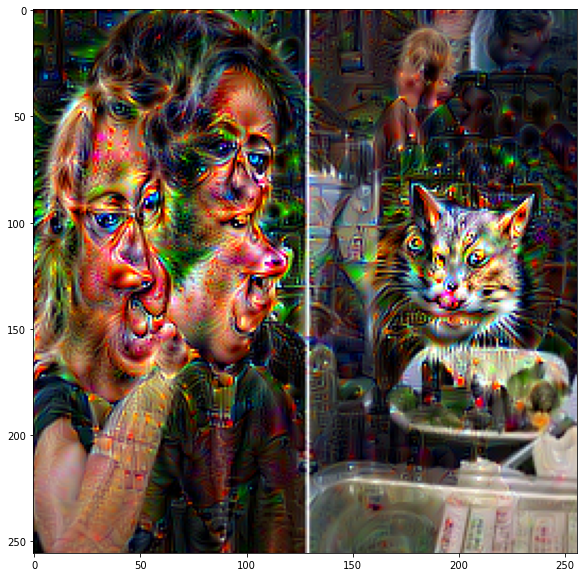

In [33]:
plt.figure(figsize=(10,10))
plt.imshow(dreamed_image)
plt.show()